In [1]:
# Install libraries
libs <- c(
        "tidyverse", "stringr", "sf", "sp",
        "dplyr", "httr", "giscoR", "scales",
        "remotes", "osmdata"
)

installed_libs <- libs %in% rownames(installed.packages())
if (any(installed_libs == F)) {
    install.packages(libs[!installed_libs])
}

# Install geojsonio using remotes if not installed
if (!"geojsonio" %in% installed.packages()) {
    remotes::install_github("ropensci/geojsonio")
}

invisible(lapply(libs, library, character.only = T))

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.3      ✔ purrr   1.0.1 
✔ tibble  3.2.1      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.4      ✔ forcats 1.0.0 
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Linking to GEOS 3.11.1, GDAL 3.

In [2]:
# Print current working directory
current_directory <- getwd()
print(current_directory)

list.files()

[1] "/home/jovyan/ReportNov-23/geometry"


[1] "ab.csv"                         "code-point-column-headers.csv" 
 [3] "dd.csv"                         "dg.csv"                        
 [5] "eh.csv"                         "fk.csv"                        
 [7] "g.csv"                          "geometry_mapping.ipynb"        
 [9] "hs.csv"                         "iv.csv"                        
[11] "ka.csv"                         "kw.csv"                        
[13] "ky.csv"                         "ml.csv"                        
[15] "output_map.png"                 "output_plot.png"               
[17] "pa.csv"                         "ph.csv"                        
[19] "practice_locations_longlat.csv" "practice_locations.csv"        
[21] "scotland_map.html"              "td.csv"                        
[23] "ze.csv"

In [3]:
# Define postcode file names
file_names <- c('ab.csv', 'dd.csv', 'dg.csv', 'eh.csv',
                'fk.csv', 'g.csv', 'hs.csv', 'iv.csv',
                'ka.csv', 'kw.csv', 'ky.csv', 'ml.csv',
                'pa.csv', 'ph.csv', 'td.csv', 'ze.csv')

# Read the header file
header_file <- "code-point-column-headers.csv"

# Define column names based on the first row of the CSV file
column_names <- c("Postcode", "Positional_quality_indicator", "PO_Box_indicator", 
                   "Total_number_of_delivery_points", "Delivery_points_used_to_create_the_CPLC",
                   "Domestic_delivery_points", "Non_domestic_delivery_points", 
                   "PO_Box_delivery_points", "Matched_address_premises", 
                   "Unmatched_delivery_points", "Eastings", "Northings", 
                   "Country_code", "NHS_regional_HA_code", "NHS_HA_code", 
                   "Admin_county_code", "Admin_district_code", "Admin_ward_code", 
                   "Postcode_type")

In [4]:
# Read the CSV files with specified column names
postcode_data <- lapply(file_names, function(file) {
  data <- read.csv(file.path(current_directory, file), header = FALSE, col.names = column_names)
  return(data)
})

# Combine the data into one dataframe
all_postcodes <- do.call(rbind, postcode_data) %>%
  select(Postcode, Eastings, Northings)

head(all_postcodes)
dim(all_postcodes)

,Postcode,Eastings,Northings
,<chr>,<int>,<int>
1,AB10 1AB,394235,806529
2,AB10 1AF,394235,806529
3,AB10 1AG,394230,806469
4,AB10 1AH,394235,806529
5,AB10 1AL,394296,806581
6,AB10 1AN,394367,806541


[1] 161012      3

In [5]:
wgs84 <- "+proj=longlat +datum=WGS84 +no_defs"

bng <- '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +datum=OSGB36 +units=m +no_defs'

ConvertCoordinates <- function(easting, northing) {
  out <- cbind(easting, northing)
  mask <- !is.na(easting)
  sp <- sp::spTransform(sp::SpatialPoints(list(easting[mask], northing[mask]), proj4string = sp::CRS(bng)), sp::CRS(wgs84))
  out[mask,] <- sp@coords
  out
}

# Creating new lat and long columns
all_postcodes$latitude <- NA
all_postcodes$longitude <- NA

# Apply the conversion function to each row
all_postcodes[, c("longitude", "latitude")] <- ConvertCoordinates(all_postcodes$Eastings, all_postcodes$Northings)

In [6]:
# Remove unneeded columns
all_postcodes <- all_postcodes %>%
    select(Postcode, latitude, longitude)

head(all_postcodes)

,Postcode,latitude,longitude
,<chr>,<dbl>,<dbl>
1,AB10 1AB,57.14979,-2.095293
2,AB10 1AF,57.14979,-2.095293
3,AB10 1AG,57.14925,-2.095374
4,AB10 1AH,57.14979,-2.095293
5,AB10 1AL,57.15026,-2.094286
6,AB10 1AN,57.14990,-2.093111


In [7]:
# datazone_data <- read_csv('/home/jovyan/ReportNov-23/postcodes_with_datazones.csv')
# head(datazone_data)

In [8]:
# Read in GP practice data
practice_data <- read_csv('/home/jovyan/ReportNov-23/GP_extended_data.csv')

practice_data <- practice_data %>%
    select(GPPracticeName, Postcode, PracticeCode)

head(practice_data)

Rows: 916 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): GPPracticeName, AddressLine1, AddressLine2, AddressLine3, AddressL...
dbl  (3): _id, PracticeCode, PracticeListSize

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


GPPracticeName,Postcode,PracticeCode
<chr>,<chr>,<dbl>
Muirhead Medical Centre,DD2 5NH,10002
The Blue Practice,PH7 3SA,10017
Aberfeldy And Kinloch Rannoch Medical Practice,PH15 2BL,10036
Grove Health Centre,DD5 1DU,10106
Alyth Health Centre,PH11 8EQ,10125
Arbroath Medical Centre,DD11 1AD,10182


In [9]:
# Merge location data and practice data
point_data <- practice_data %>%
    full_join(all_postcodes, by = c("Postcode" = "Postcode")) %>%
    filter(!is.na(GPPracticeName))

head(point_data)

GPPracticeName,Postcode,PracticeCode,latitude,longitude
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Muirhead Medical Centre,DD2 5NH,10002,56.49572,-3.064575
The Blue Practice,PH7 3SA,10017,56.37054,-3.841282
Aberfeldy And Kinloch Rannoch Medical Practice,PH15 2BL,10036,56.61865,-3.869156
Grove Health Centre,DD5 1DU,10106,56.46878,-2.881552
Alyth Health Centre,PH11 8EQ,10125,56.61825,-3.227675
Arbroath Medical Centre,DD11 1AD,10182,56.55912,-2.579306


In [10]:
# Read in GP List size data
practice_size_data <- read_csv('/home/jovyan/ReportNov-23/GP_practice_populations_apr22.csv')

practice_size_data <- practice_size_data %>%
    filter(Sex == "All") %>%
    select(PracticeCode, AllAges) 

head(practice_size_data)

Rows: 2748 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): HB, HSCP, Sex
dbl (14): Date, PracticeCode, AllAges, Ages0to4, Ages5to14, Ages15to24, Ages...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PracticeCode,AllAges
<dbl>,<dbl>
10002,8102
10017,6620
10036,4758
10106,6075
10125,4385
10182,9188


In [11]:
# Merge practice data and list size data
point_size_data <- point_data %>%
    full_join(practice_size_data, by = c("PracticeCode" = "PracticeCode")) %>%
    filter(!is.na(GPPracticeName)) %>%
    rename("ListSize" = "AllAges") %>%
    select(-Postcode)

head(point_size_data)

GPPracticeName,PracticeCode,latitude,longitude,ListSize
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Muirhead Medical Centre,10002,56.49572,-3.064575,8102
The Blue Practice,10017,56.37054,-3.841282,6620
Aberfeldy And Kinloch Rannoch Medical Practice,10036,56.61865,-3.869156,4758
Grove Health Centre,10106,56.46878,-2.881552,6075
Alyth Health Centre,10125,56.61825,-3.227675,4385
Arbroath Medical Centre,10182,56.55912,-2.579306,9188


In [12]:
na_coords <- point_size_data %>%
    filter(is.na(longitude))

dim(na_coords)
head(na_coords)

[1] 4 5

GPPracticeName,PracticeCode,latitude,longitude,ListSize
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Whitfield Surgery,12901,NA,NA,4204
Dunblane Medical Practice,25243,NA,NA,10603
Elmbank Group Practice,30203,NA,NA,11442
Ashgrove Group Practice,78330,NA,NA,7266


In [13]:
# Manually replace missing values

point_size_data$latitude[point_size_data$GPPracticeName == "Whitfield Surgery"] <- 56.48964
point_size_data$longitude[point_size_data$GPPracticeName == "Whitfield Surgery"] <- -2.91704

point_size_data$latitude[point_size_data$GPPracticeName == "Dunblane Medical Practice"] <- 56.18777
point_size_data$longitude[point_size_data$GPPracticeName == "Dunblane Medical Practice"] <- -3.96845

point_size_data$latitude[point_size_data$GPPracticeName == "Elmbank Group Practice"] <- 57.15281
point_size_data$longitude[point_size_data$GPPracticeName == "Elmbank Group Practice"] <- -2.14419

point_size_data$latitude[point_size_data$GPPracticeName == "Ashgrove Group Practice"] <- 55.87475
point_size_data$longitude[point_size_data$GPPracticeName == "Ashgrove Group Practice"] <- -3.62148

In [14]:
na_coords_check <- point_size_data %>%
    filter(is.na(longitude))

dim(na_coords_check)
head(na_coords_check)

[1] 0 5

GPPracticeName,PracticeCode,latitude,longitude,ListSize
<chr>,<dbl>,<dbl>,<dbl>,<dbl>


In [15]:
head(point_size_data)

GPPracticeName,PracticeCode,latitude,longitude,ListSize
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Muirhead Medical Centre,10002,56.49572,-3.064575,8102
The Blue Practice,10017,56.37054,-3.841282,6620
Aberfeldy And Kinloch Rannoch Medical Practice,10036,56.61865,-3.869156,4758
Grove Health Centre,10106,56.46878,-2.881552,6075
Alyth Health Centre,10125,56.61825,-3.227675,4385
Arbroath Medical Centre,10182,56.55912,-2.579306,9188


In [16]:
# Write dataset to file
write_csv(point_size_data, "practice_locations_longlat.csv")

In [17]:
CRSlonglat <- 
    "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

locations_sf <- point_size_data |>
    sf::st_as_sf(
      coords = c("longitude", "latitude"),
      crs = CRSlonglat
    )

In [18]:
head(locations_sf)

ERROR while rich displaying an object: Error in loadNamespace(x): there is no package called ‘geojsonio’

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_geojson.sf(obj)
8. repr_geojson(geo

GPPracticeName,PracticeCode,ListSize,geometry
<chr>,<dbl>,<dbl>,<POINT [°]>
Muirhead Medical Centre,10002,8102,POINT (-3.064575 56.49572)
The Blue Practice,10017,6620,POINT (-3.841282 56.37054)
Aberfeldy And Kinloch Rannoch Medical Practice,10036,4758,POINT (-3.869156 56.61865)
Grove Health Centre,10106,6075,POINT (-2.881552 56.46878)
Alyth Health Centre,10125,4385,POINT (-3.227675 56.61825)
Arbroath Medical Centre,10182,9188,POINT (-2.579306 56.55912)


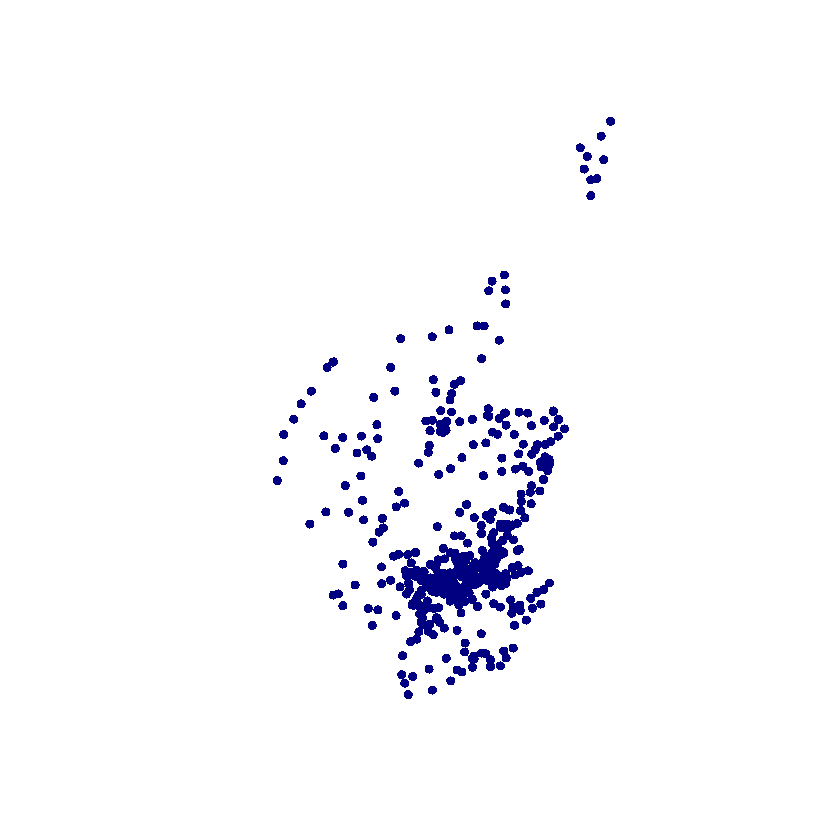

In [19]:
plot(st_geometry(locations_sf), pch=16, col="navy")

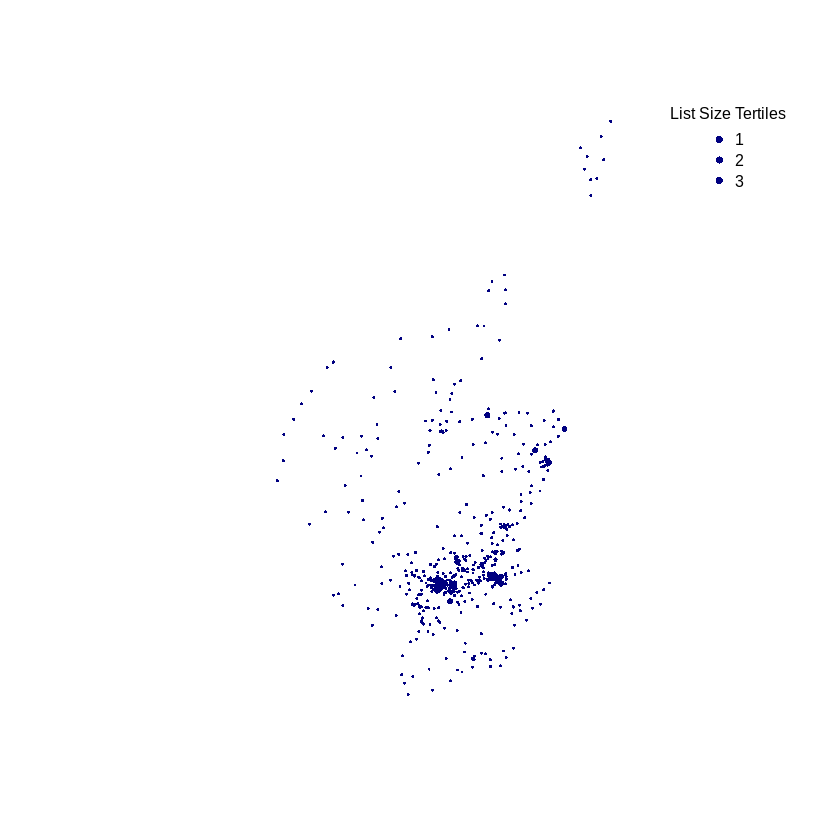

In [20]:
# Create quintiles based on ListSize
locations_sf$ListSizeQuintile <- cut(locations_sf$ListSize, breaks = 3, labels = FALSE)

# Plot with quintile-based sizes and 50% opacity
plot(
  st_geometry(locations_sf),
  pch = 16,
  col = "navy",
  cex = locations_sf$ListSizeQuintile / 3,  # Divide by the number of categories (quintiles)
  bg = adjustcolor("navy", alpha.f = 0.7)  # Set opacity
)

# Add a legend
legend("topright", legend = levels(factor(locations_sf$ListSizeQuintile)),
       title = "List Size Tertiles", pch = 16, col = "navy", bty = "n", cex = 0.8)

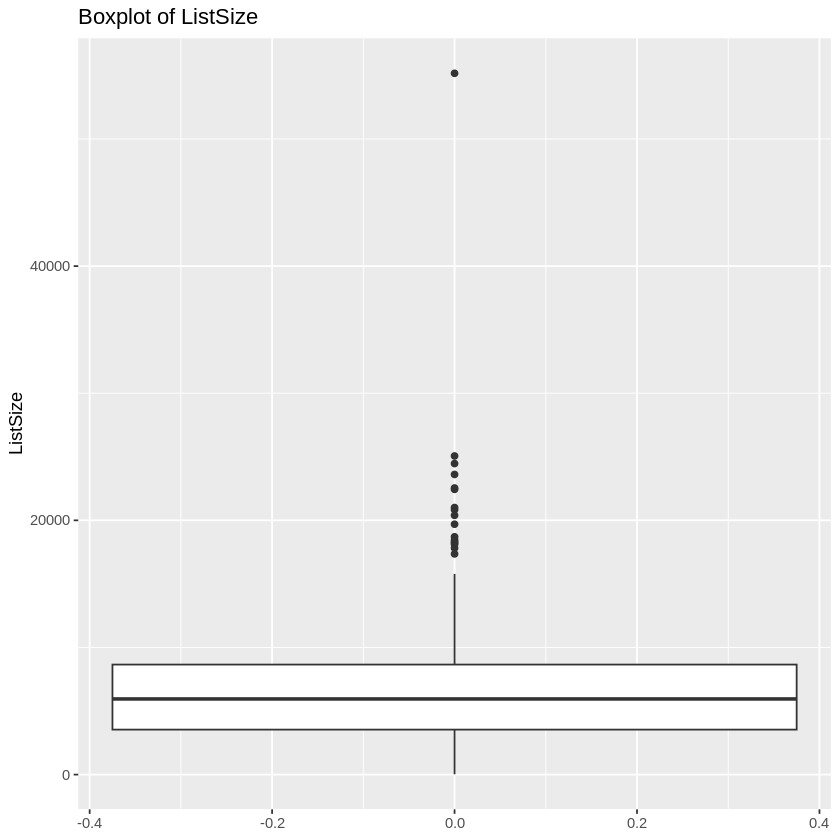

In [21]:
library(ggplot2)

# Boxplot of ListSize
ggplot(locations_sf, aes(y = ListSize)) +
  geom_boxplot() +
  labs(title = "Boxplot of ListSize")

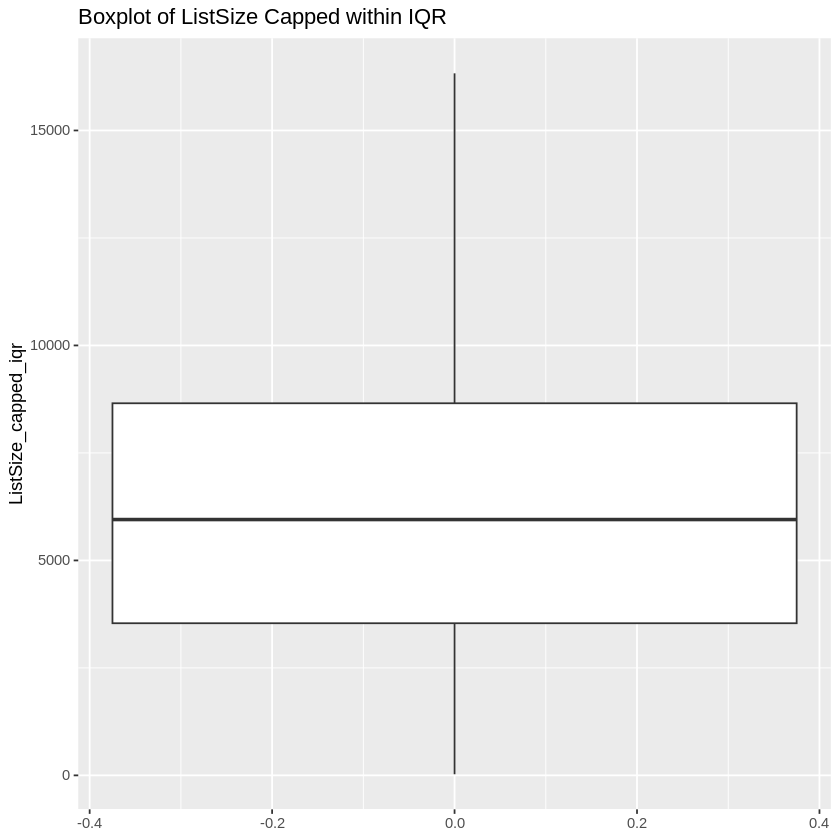

In [22]:
# Calculate the lower and upper bounds using IQR
lower_bound <- quantile(locations_sf$ListSize, 0.25) - 1.5 * IQR(locations_sf$ListSize)
upper_bound <- quantile(locations_sf$ListSize, 0.75) + 1.5 * IQR(locations_sf$ListSize)

# Cap values outside the bounds
locations_sf$ListSize_capped_iqr <- pmin(pmax(locations_sf$ListSize, lower_bound), upper_bound)

# Boxplot of ListSize_capped_iqr
ggplot(locations_sf, aes(y = ListSize_capped_iqr)) +
  geom_boxplot() +
  labs(title = "Boxplot of ListSize Capped within IQR")

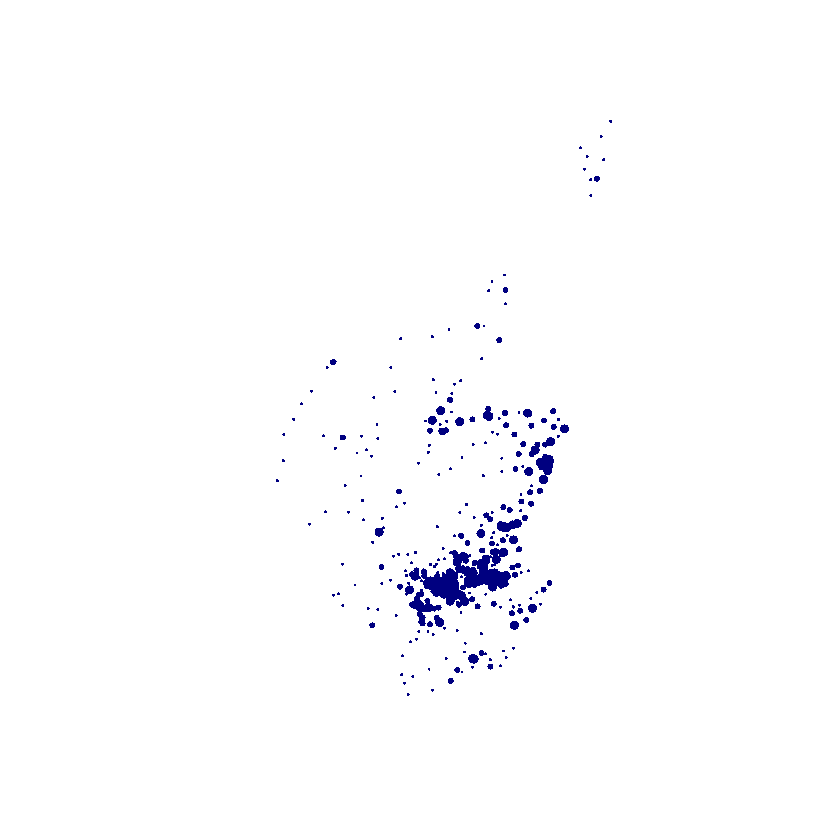

In [23]:
# Create quintiles based on ListSize_capped
locations_sf$ListSizeQuintile <- cut(locations_sf$ListSize_capped_iqr, breaks = 3, labels = FALSE)

# Plot with quintile-based sizes and 50% opacity
plot(
  st_geometry(locations_sf),
  pch = 16,
  col = "navy",
  cex = locations_sf$ListSizeQuintile / 3,  # Divide by the number of categories (quintiles)
  bg = adjustcolor("navy", alpha.f = 0.7)  # Set opacity
)

In [24]:
install.packages("htmlwidgets")
library(htmlwidgets)

# Create the leaflet map
map <- leaflet() %>%
  setView(lng = -4.2026, lat = 56.4907, zoom = 6) %>%
  addProviderTiles("OpenStreetMap.Mapnik")

# Save the map as an HTML file
saveWidget(map, file = "scotland_map.html")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



ERROR: Error in addProviderTiles(., "OpenStreetMap.Mapnik"): could not find function "addProviderTiles"


In [ ]:
head(locations_sf)

In [ ]:
# Write dataset to file
write_csv(locations_sf, "practice_locations.csv")